In [38]:
%matplotlib inline

# TODO: Purge packages that are not used
import seaborn as sns
import pandas as pd
import libpysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx # For querying OSM using shapefiles
from shapely import wkt, intersection
from shapely.ops import unary_union # To combine multiple shapefiles into one

pd.options.display.max_seq_items = 2000

# Two crs, one for coordinates and a projected one to compute areas
crs_geographical = "epsg:4326"
crs_projected = "epsg:28992"


In [35]:
# Load the CBS buurtkaart into a GeoDataFrame
# TODO: Select the right columns, these are just a few for building the method
path = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/WijkBuurtkaart_2020_v3/buurt_2020_v3.shp'
columns = ["BU_CODE", "GM_NAAM", "P_00_14_JR", 'P_00_14_JR', 'P_65_EO_JR', 'P_HOOGINKP', 'P_LAAGINKP']
gdf = gpd.read_file(path, include_fields=columns)

# Select the relevant rows
# TODO: Use more cities than just amsterdam
gdf = gdf[gdf["GM_NAAM"] == "Amsterdam"]

# Transfrom the buurtkaart to normal coordinates used by normal people
gdf.to_crs(crs_geographical, inplace=True)
gdf["blue_geometry"] = np.nan
gdf["green_geometry"] = np.nan

# Features that can be considered blue space
blue_features = {
    'natural': 'water'
}

# Features that can be considered green space
green_features = {
    'landuse': 'recreation_ground',
    'landuse': 'village_green',
    'landuse': 'grass',
    'landuse': 'forest', 
    'landuse': 'flowerbed',
    'landuse': 'meadow',
    'leisure': 'garden',
    'leisure': "park",
    'natural': 'tree',
    'natural': 'tree_row',
    'natural': 'scrub',
    'natural': 'wood',
    'natural': 'heath',
    'natural': 'grassland',
    "barrier": 'hedge'
}

# Get water and greenspace for all neighborhoods 
cnt = 0
no_blue_count = 0
no_green_count = 0
for i, row in gdf.iterrows():
    
    print(f"{cnt}/{len(gdf)-1}", end='\r')
    cnt += 1

    try:
        # Get the bluespace for this neighborhood from OSM
        blue = osmnx.features.features_from_polygon(row["geometry"], blue_features)

        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in blue["geometry"]:
            l.append(unit)

        neighborhood_blue = intersection(row["geometry"], unary_union(l))
        gdf.loc[gdf["BU_CODE"] == row["BU_CODE"], "blue_geometry"] = neighborhood_blue

    except:
        no_blue_count += 1
    
    try:
        # Get the greenspace for this neighborhood from OSM
        green = osmnx.features.features_from_polygon(row["geometry"], green_features)
       

        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in green["geometry"]:
            l.append(unit)

        neighborhood_green = intersection(row["geometry"], unary_union(l))
        gdf.loc[gdf["BU_CODE"] == row["BU_CODE"], "green_geometry"] = neighborhood_green 

    except:
        no_green_count += 1


print(f"{no_blue_count} neighborhoods have no bluespace at all")
print(f"{no_green_count} neighborhoods have no greenspace at all")


30 neighborhoods have no bluespace at all
175 neighborhoods have no greenspace at all


In [3]:
# Visualise some information
gdf.info()
gdf.head(5)
gdf.columns

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13903 entries, 0 to 13902
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BU_CODE     13903 non-null  object  
 1   GM_NAAM     13903 non-null  object  
 2   P_00_14_JR  13903 non-null  int64   
 3   P_65_EO_JR  13903 non-null  int64   
 4   P_LAAGINKP  13903 non-null  int64   
 5   P_HOOGINKP  13903 non-null  int64   
 6   geometry    13903 non-null  geometry
dtypes: geometry(1), int64(4), object(2)
memory usage: 760.4+ KB


Index(['BU_CODE', 'GM_NAAM', 'P_00_14_JR', 'P_65_EO_JR', 'P_LAAGINKP',
       'P_HOOGINKP', 'geometry'],
      dtype='object')

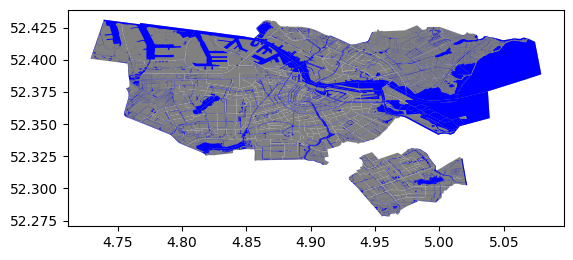

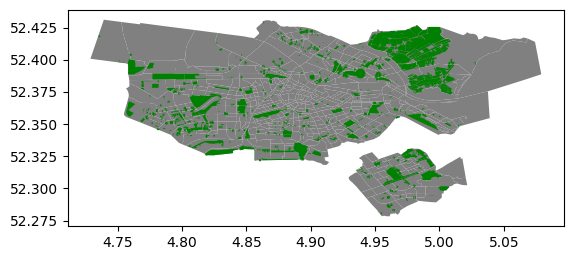

In [36]:
# Visualise the blue- and greenspace
# TODO: Make it look nice

fig, ax = plt.subplots(1,1)
gdf.set_geometry("geometry", inplace=True)
gdf.plot(ax=ax, color="grey")
gdf.set_geometry("blue_geometry", inplace=True)
gdf.plot(ax=ax, color="blue")
plt.show()

fig, ax = plt.subplots(1,1)
gdf.set_geometry("geometry", inplace=True)
gdf.plot(ax=ax, color="grey")
gdf.set_geometry("green_geometry", inplace=True)
gdf.plot(ax=ax, color="green")
plt.show()


In [62]:
# Use the geometries to calculate %green and %blue
def calc_blue(geo, blue_geo):
    if (blue_geo) is not None:
        return blue_geo.area / geo.area
    else:
        return 0

def calc_green(geo, green_geo):
    if (green_geo) is not None:
        return green_geo.area / geo.area
    else:
        return 0

'''
#TODO: Maybe green and blue can overlap?
def calc_blue_green(geo, blue_geo, green_geo):
    if (green_geo) is not None and (blue_geo) is not None:
        return (green_geo.area + blue_geo.area) / geo.area
    elif (green_geo) is not None:
        return green_geo.area / geo.area
    elif (blue_geo) is not None:
        return blue_geo.area / geo.area
    else:
        return 0
'''

# TODO: make this make sense, geometries are in different CRS format
gdf.set_geometry("geometry", inplace=True)
gdf.to_crs(crs_projected, inplace=True)
gdf.set_geometry("green_geometry", inplace=True)
gdf.to_crs(crs_projected, inplace=True)
gdf.set_geometry("blue_geometry", inplace=True)
gdf.to_crs(crs_projected, inplace=True)

gdf["percent_blue"] = gdf.apply(lambda row: calc_blue(row["geometry"], row["blue_geometry"]), axis = 1)
gdf["percent_green"] = gdf.apply(lambda row: calc_green(row["geometry"], row["green_geometry"]), axis = 1)
# gdf["percent_blue_green"] = gdf.apply(lambda row: calc_blue_green(row["geometry"], row["blue_geometry"], row["green_geometry"]), axis = 1)
gdf.to_crs(crs_geographical, inplace=True)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

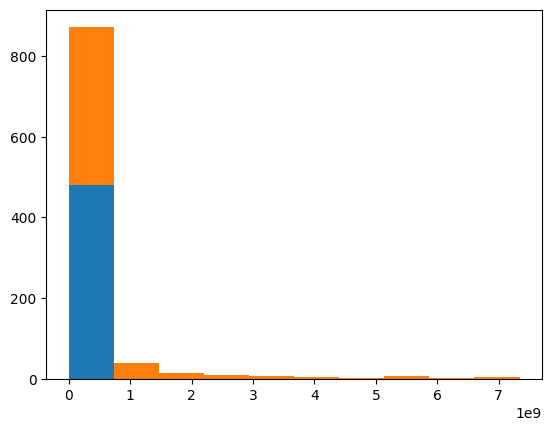

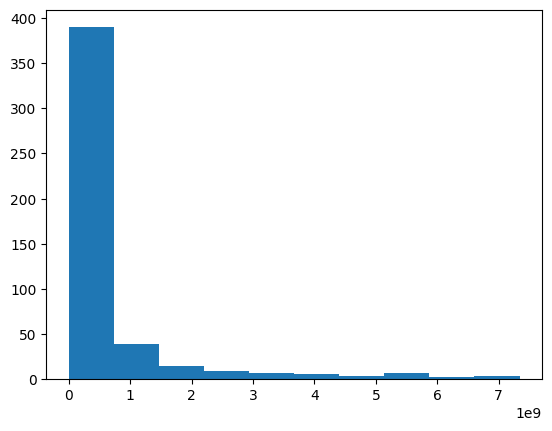

21      1.425425e+05
22      3.378214e+07
4163    0.000000e+00
4164    0.000000e+00
4165    0.000000e+00
            ...     
4637    0.000000e+00
4638    1.944848e+09
4639    5.056294e+07
4640    0.000000e+00
4641    0.000000e+00
Name: percent_green, Length: 481, dtype: float64
                                               geometry  \
21    MULTIPOLYGON (((126797.155 488071.848, 126811....   
22    MULTIPOLYGON (((126646.374 486373.397, 126642....   
4163  POLYGON ((121890.334 487818.898, 121957.842 48...   
4164  POLYGON ((121585.791 487654.681, 121624.240 48...   
4165  POLYGON ((121799.802 487534.283, 121824.012 48...   
...                                                 ...   
4637  POLYGON ((127532.966 478781.318, 127568.077 47...   
4638  POLYGON ((128041.368 479401.527, 128045.124 47...   
4639  POLYGON ((128807.439 478781.404, 128807.542 47...   
4640  POLYGON ((129532.825 480196.610, 129553.597 48...   
4641  POLYGON ((129705.432 481901.714, 129707.527 48...   

           

In [61]:
plt.hist(gdf[["percent_blue", "percent_green"]], stacked=True)
plt.show()

plt.hist(gdf["percent_green"])
plt.show()

print(gdf["percent_green"])

print(gdf[["geometry", "green_geometry", "blue_geometry"]])

In [21]:
# Load Depression risk data fromm buurtatlas
# TODO: Deal with missing values :(
# TODO: Merge data into the big gdf
# TODO: Get buurtatlas data for the other cities we want to use
path_buurtatlas = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/data/MATIG_HOOG_RISICO_ANGST_DEPRESSIE_BUURTEN.csv'
df_buurtatlas = pd.read_csv(path_buurtatlas)
df_buurtatlas["18_en_ouder"].fillna(df['price'].mean(), inplace = True)

df_buurtatlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEBIED_NAAM  481 non-null    object 
 1   18_en_ouder  447 non-null    float64
 2   18_tot_65    443 non-null    float64
 3   65_en_ouder  401 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.2+ KB


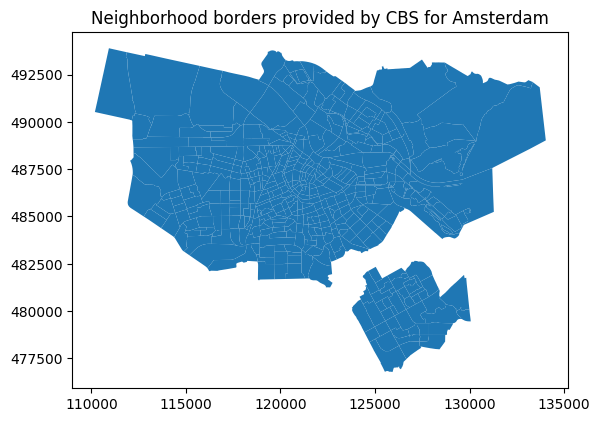

In [38]:
# Visualise the borders in Amsterdam to compare to buurtatlas
gdf_amsterdam = gdf[gdf["GM_NAAM"] == "Amsterdam"]
gdf_amsterdam.plot()

plt.title("Neighborhood borders provided by CBS for Amsterdam")
plt.show()


In [36]:
# Compare the names of BuurtAtlas and CBS 
# They should be the same
# TODO: Deal with the few exceptions manually
names_cbs = gdf_amsterdam.sort_values("BU_NAAM")["BU_NAAM"].unique()
names_ba = df_buurtatlas.sort_values("GEBIED_NAAM")["GEBIED_NAAM"].unique()

for i in range(len(names_cbs)):
    if names_cbs[i] not in names_ba:
        print(f"{names_cbs[i]} is not found in the buurtatlas names")

for i in range(len(names_ba)):
    if names_ba[i] not in names_cbs:
        print(f"{names_ba[i]} is not found in the CBS names")

BelgiÃ«plein e.o. is not found in the buurtatlas names
None is not found in the buurtatlas names
Belgiëplein e.o. is not found in the buurtatlas names
Gemeente: Amsterdam is not found in the buurtatlas names
Nederland is not found in the buurtatlas names
nan is not found in the buurtatlas names
